# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sentiment-adjusted topics (BPW) most highly correlated with GDP growth (out of 200 topics estimated on articles published before 2008 using all sources). I forecast GDP growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 sentiment-adjusted topics, BPW (<=2007, 200 topics, all sources).
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                      # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11572
EM iteration 50, llf=-11397, convergence criterion=1.347e-06
EM converged at iteration 58, llf=-11397, convergence criterion=9.9425e-07 < tolerance=1e-06
EM start iterations, llf=-11584
EM iteration 50, llf=-11409, convergence criterion=1.3469e-06
EM converged at iteration 58, llf=-11409, convergence criterion=9.9426e-07 < tolerance=1e-06
EM start iterations, llf=-11642
EM iteration 50, llf=-11464, convergence criterion=1.3475e-06
EM converged at iteration 58, llf=-11463, convergence criterion=9.9472e-07 < tolerance=1e-06
EM start iterations, llf=-11650
EM iteration 50, llf=-11472, convergence criterion=1.3443e-06
EM converged at iteration 58, llf=-11472, convergence criterion=9.9277e-07 < tolerance=1e-06
EM start iterations, llf=-11714
EM iteration 50, llf=-11537, convergence criterion=1.34e-06
EM converged at iteration 58, llf=-11537, convergence criterion=9.8988e-07 < tolerance=1e-06
EM start iterations, llf=-11722
EM iteration 50, llf=-11545, converg

EM converged at iteration 35, llf=-12594, convergence criterion=9.8463e-07 < tolerance=1e-06
EM start iterations, llf=-12810
EM converged at iteration 35, llf=-12643, convergence criterion=9.7603e-07 < tolerance=1e-06
EM start iterations, llf=-12820
EM converged at iteration 36, llf=-12653, convergence criterion=9.5397e-07 < tolerance=1e-06
EM start iterations, llf=-12866
EM converged at iteration 36, llf=-12699, convergence criterion=9.5134e-07 < tolerance=1e-06
EM start iterations, llf=-12915
EM converged at iteration 35, llf=-12746, convergence criterion=9.8925e-07 < tolerance=1e-06
EM start iterations, llf=-12967
EM converged at iteration 35, llf=-12796, convergence criterion=9.8098e-07 < tolerance=1e-06
EM start iterations, llf=-12967
EM converged at iteration 35, llf=-12796, convergence criterion=9.8098e-07 < tolerance=1e-06
EM start iterations, llf=-12976
EM converged at iteration 35, llf=-12805, convergence criterion=9.8283e-07 < tolerance=1e-06
EM start iterations, llf=-13023


EM start iterations, llf=-14452
EM converged at iteration 35, llf=-14264, convergence criterion=9.6339e-07 < tolerance=1e-06
EM start iterations, llf=-14464
EM converged at iteration 35, llf=-14277, convergence criterion=9.6187e-07 < tolerance=1e-06
EM start iterations, llf=-14513
EM converged at iteration 35, llf=-14323, convergence criterion=9.5542e-07 < tolerance=1e-06
EM start iterations, llf=-14513
EM converged at iteration 35, llf=-14323, convergence criterion=9.5542e-07 < tolerance=1e-06
EM start iterations, llf=-14519
EM converged at iteration 35, llf=-14331, convergence criterion=9.5925e-07 < tolerance=1e-06
EM start iterations, llf=-14572
EM converged at iteration 35, llf=-14384, convergence criterion=9.5455e-07 < tolerance=1e-06
EM start iterations, llf=-14580
EM converged at iteration 35, llf=-14391, convergence criterion=9.9504e-07 < tolerance=1e-06
EM start iterations, llf=-14628
EM converged at iteration 35, llf=-14438, convergence criterion=9.8885e-07 < tolerance=1e-06


EM start iterations, llf=-16149
EM converged at iteration 26, llf=-15948, convergence criterion=9.9835e-07 < tolerance=1e-06
EM start iterations, llf=-16153
EM converged at iteration 26, llf=-15950, convergence criterion=9.898e-07 < tolerance=1e-06
EM start iterations, llf=-16201
EM converged at iteration 26, llf=-15997, convergence criterion=9.887e-07 < tolerance=1e-06
EM start iterations, llf=-16210
EM converged at iteration 26, llf=-16005, convergence criterion=9.9383e-07 < tolerance=1e-06
EM start iterations, llf=-16264
EM converged at iteration 26, llf=-16057, convergence criterion=9.9045e-07 < tolerance=1e-06
EM start iterations, llf=-16271
EM converged at iteration 26, llf=-16065, convergence criterion=9.9308e-07 < tolerance=1e-06
EM start iterations, llf=-16318
EM converged at iteration 26, llf=-16113, convergence criterion=9.9528e-07 < tolerance=1e-06
EM start iterations, llf=-16318
EM converged at iteration 26, llf=-16113, convergence criterion=9.9528e-07 < tolerance=1e-06
EM

EM start iterations, llf=-17832
EM converged at iteration 29, llf=-17617, convergence criterion=9.512e-07 < tolerance=1e-06
EM start iterations, llf=-17875
EM converged at iteration 29, llf=-17660, convergence criterion=9.5053e-07 < tolerance=1e-06
EM start iterations, llf=-17885
EM converged at iteration 29, llf=-17669, convergence criterion=9.465e-07 < tolerance=1e-06
EM start iterations, llf=-17741
EM converged at iteration 29, llf=-17530, convergence criterion=9.5325e-07 < tolerance=1e-06
EM start iterations, llf=-17741
EM converged at iteration 29, llf=-17530, convergence criterion=9.5325e-07 < tolerance=1e-06
EM start iterations, llf=-17746
EM converged at iteration 29, llf=-17534, convergence criterion=9.4842e-07 < tolerance=1e-06
EM start iterations, llf=-17795
EM converged at iteration 29, llf=-17582, convergence criterion=9.4555e-07 < tolerance=1e-06
EM start iterations, llf=-17808
EM converged at iteration 29, llf=-17596, convergence criterion=9.5534e-07 < tolerance=1e-06
EM

EM iteration 50, llf=-11599, convergence criterion=1.4118e-06
EM converged at iteration 60, llf=-11599, convergence criterion=9.7693e-07 < tolerance=1e-06
EM start iterations, llf=-11840
EM iteration 50, llf=-11659, convergence criterion=1.403e-06
EM converged at iteration 60, llf=-11659, convergence criterion=9.7087e-07 < tolerance=1e-06
EM start iterations, llf=-11850
EM iteration 50, llf=-11669, convergence criterion=1.2581e-06
EM converged at iteration 56, llf=-11669, convergence criterion=9.9816e-07 < tolerance=1e-06
EM start iterations, llf=-11900
EM iteration 50, llf=-11720, convergence criterion=1.2533e-06
EM converged at iteration 56, llf=-11719, convergence criterion=9.9447e-07 < tolerance=1e-06
EM start iterations, llf=-11909
EM iteration 50, llf=-11729, convergence criterion=1.2528e-06
EM converged at iteration 56, llf=-11729, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-11958
EM iteration 50, llf=-11778, convergence criterion=1.2753e-06
EM co

EM start iterations, llf=-13152
EM converged at iteration 36, llf=-12972, convergence criterion=9.9943e-07 < tolerance=1e-06
EM start iterations, llf=-13162
EM converged at iteration 36, llf=-12982, convergence criterion=9.9795e-07 < tolerance=1e-06
EM start iterations, llf=-13210
EM converged at iteration 36, llf=-13030, convergence criterion=9.7921e-07 < tolerance=1e-06
EM start iterations, llf=-13218
EM converged at iteration 36, llf=-13036, convergence criterion=9.8302e-07 < tolerance=1e-06
EM start iterations, llf=-13276
EM converged at iteration 36, llf=-13092, convergence criterion=9.7809e-07 < tolerance=1e-06
EM start iterations, llf=-13287
EM converged at iteration 36, llf=-13104, convergence criterion=9.8339e-07 < tolerance=1e-06
EM start iterations, llf=-13333
EM converged at iteration 36, llf=-13150, convergence criterion=9.7356e-07 < tolerance=1e-06
EM start iterations, llf=-13333
EM converged at iteration 36, llf=-13150, convergence criterion=9.7356e-07 < tolerance=1e-06


EM start iterations, llf=-14763
EM converged at iteration 37, llf=-14567, convergence criterion=9.6134e-07 < tolerance=1e-06
EM start iterations, llf=-14809
EM converged at iteration 37, llf=-14613, convergence criterion=9.617e-07 < tolerance=1e-06
EM start iterations, llf=-14817
EM converged at iteration 37, llf=-14621, convergence criterion=9.6394e-07 < tolerance=1e-06
EM start iterations, llf=-14865
EM converged at iteration 37, llf=-14668, convergence criterion=9.6362e-07 < tolerance=1e-06
EM start iterations, llf=-14865
EM converged at iteration 37, llf=-14668, convergence criterion=9.6362e-07 < tolerance=1e-06
EM start iterations, llf=-14876
EM converged at iteration 37, llf=-14679, convergence criterion=9.6069e-07 < tolerance=1e-06
EM start iterations, llf=-14923
EM converged at iteration 37, llf=-14725, convergence criterion=9.5781e-07 < tolerance=1e-06
EM start iterations, llf=-14934
EM converged at iteration 36, llf=-14736, convergence criterion=9.6126e-07 < tolerance=1e-06
E

EM start iterations, llf=-16510
EM converged at iteration 29, llf=-16299, convergence criterion=9.3701e-07 < tolerance=1e-06
EM start iterations, llf=-16510
EM converged at iteration 29, llf=-16299, convergence criterion=9.3701e-07 < tolerance=1e-06
EM start iterations, llf=-16518
EM converged at iteration 29, llf=-16306, convergence criterion=9.3238e-07 < tolerance=1e-06
EM start iterations, llf=-16567
EM converged at iteration 28, llf=-16354, convergence criterion=9.972e-07 < tolerance=1e-06
EM start iterations, llf=-16577
EM converged at iteration 28, llf=-16365, convergence criterion=9.9961e-07 < tolerance=1e-06
EM start iterations, llf=-16627
EM converged at iteration 28, llf=-16414, convergence criterion=9.9669e-07 < tolerance=1e-06
EM start iterations, llf=-16638
EM converged at iteration 28, llf=-16426, convergence criterion=9.9564e-07 < tolerance=1e-06
EM start iterations, llf=-16690
EM converged at iteration 28, llf=-16478, convergence criterion=9.9238e-07 < tolerance=1e-06
E

EM start iterations, llf=-17986
EM converged at iteration 30, llf=-17767, convergence criterion=9.9237e-07 < tolerance=1e-06
EM start iterations, llf=-17993
EM converged at iteration 31, llf=-17775, convergence criterion=9.7369e-07 < tolerance=1e-06
EM start iterations, llf=-18048
EM converged at iteration 31, llf=-17828, convergence criterion=9.7227e-07 < tolerance=1e-06
EM start iterations, llf=-18055
EM converged at iteration 31, llf=-17834, convergence criterion=9.7074e-07 < tolerance=1e-06
EM start iterations, llf=-18110
EM converged at iteration 31, llf=-17889, convergence criterion=9.6904e-07 < tolerance=1e-06
EM start iterations, llf=-18110
EM converged at iteration 31, llf=-17889, convergence criterion=9.6904e-07 < tolerance=1e-06
EM start iterations, llf=-18116
EM converged at iteration 31, llf=-17896, convergence criterion=9.7058e-07 < tolerance=1e-06
EM start iterations, llf=-18169
EM converged at iteration 31, llf=-17948, convergence criterion=9.6625e-07 < tolerance=1e-06


EM start iterations, llf=-12025
EM iteration 50, llf=-11850, convergence criterion=1.4793e-06
EM converged at iteration 63, llf=-11850, convergence criterion=9.7175e-07 < tolerance=1e-06
EM start iterations, llf=-12065
EM iteration 50, llf=-11885, convergence criterion=1.4141e-06
EM converged at iteration 60, llf=-11885, convergence criterion=9.9526e-07 < tolerance=1e-06
EM start iterations, llf=-12076
EM iteration 50, llf=-11895, convergence criterion=1.4092e-06
EM converged at iteration 60, llf=-11894, convergence criterion=9.9027e-07 < tolerance=1e-06
EM start iterations, llf=-12140
EM iteration 50, llf=-11962, convergence criterion=1.2182e-06
EM converged at iteration 56, llf=-11962, convergence criterion=9.6635e-07 < tolerance=1e-06
EM start iterations, llf=-12140
EM iteration 50, llf=-11962, convergence criterion=1.2182e-06
EM converged at iteration 56, llf=-11962, convergence criterion=9.6635e-07 < tolerance=1e-06
EM start iterations, llf=-12144
EM iteration 50, llf=-11964, conv

EM start iterations, llf=-13384
EM converged at iteration 42, llf=-13204, convergence criterion=9.7455e-07 < tolerance=1e-06
EM start iterations, llf=-13430
EM converged at iteration 42, llf=-13249, convergence criterion=9.813e-07 < tolerance=1e-06
EM start iterations, llf=-13438
EM converged at iteration 42, llf=-13256, convergence criterion=9.6501e-07 < tolerance=1e-06
EM start iterations, llf=-13476
EM converged at iteration 42, llf=-13295, convergence criterion=9.6372e-07 < tolerance=1e-06
EM start iterations, llf=-13476
EM converged at iteration 42, llf=-13295, convergence criterion=9.6372e-07 < tolerance=1e-06
EM start iterations, llf=-13490
EM converged at iteration 42, llf=-13310, convergence criterion=9.6577e-07 < tolerance=1e-06
EM start iterations, llf=-13522
EM converged at iteration 42, llf=-13344, convergence criterion=9.8803e-07 < tolerance=1e-06
EM start iterations, llf=-13534
EM converged at iteration 45, llf=-13357, convergence criterion=9.7291e-07 < tolerance=1e-06
E

EM start iterations, llf=-15055
EM converged at iteration 39, llf=-14855, convergence criterion=9.8613e-07 < tolerance=1e-06
EM start iterations, llf=-15055
EM converged at iteration 39, llf=-14855, convergence criterion=9.8613e-07 < tolerance=1e-06
EM start iterations, llf=-15066
EM converged at iteration 39, llf=-14867, convergence criterion=9.848e-07 < tolerance=1e-06
EM start iterations, llf=-15118
EM converged at iteration 39, llf=-14918, convergence criterion=9.8832e-07 < tolerance=1e-06
EM start iterations, llf=-15128
EM converged at iteration 39, llf=-14929, convergence criterion=9.9256e-07 < tolerance=1e-06
EM start iterations, llf=-15186
EM converged at iteration 39, llf=-14985, convergence criterion=9.8989e-07 < tolerance=1e-06
EM start iterations, llf=-15191
EM converged at iteration 39, llf=-14991, convergence criterion=9.9135e-07 < tolerance=1e-06
EM start iterations, llf=-15243
EM converged at iteration 39, llf=-15042, convergence criterion=9.8283e-07 < tolerance=1e-06
E

EM start iterations, llf=-16747
EM converged at iteration 32, llf=-16536, convergence criterion=9.5941e-07 < tolerance=1e-06
EM start iterations, llf=-16753
EM converged at iteration 33, llf=-16543, convergence criterion=9.7696e-07 < tolerance=1e-06
EM start iterations, llf=-16806
EM converged at iteration 33, llf=-16595, convergence criterion=9.8422e-07 < tolerance=1e-06
EM start iterations, llf=-16814
EM converged at iteration 33, llf=-16603, convergence criterion=9.8251e-07 < tolerance=1e-06
EM start iterations, llf=-16868
EM converged at iteration 33, llf=-16656, convergence criterion=9.7863e-07 < tolerance=1e-06
EM start iterations, llf=-16868
EM converged at iteration 33, llf=-16656, convergence criterion=9.7863e-07 < tolerance=1e-06
EM start iterations, llf=-16875
EM converged at iteration 33, llf=-16663, convergence criterion=9.7652e-07 < tolerance=1e-06
EM start iterations, llf=-16924
EM converged at iteration 33, llf=-16711, convergence criterion=9.8022e-07 < tolerance=1e-06


EM start iterations, llf=-18232
EM converged at iteration 34, llf=-18014, convergence criterion=9.7688e-07 < tolerance=1e-06
EM start iterations, llf=-18278
EM converged at iteration 34, llf=-18059, convergence criterion=9.8257e-07 < tolerance=1e-06
EM start iterations, llf=-18278
EM converged at iteration 34, llf=-18059, convergence criterion=9.8257e-07 < tolerance=1e-06
EM start iterations, llf=-18287
EM converged at iteration 34, llf=-18068, convergence criterion=9.7757e-07 < tolerance=1e-06
EM start iterations, llf=-18336
EM converged at iteration 34, llf=-18117, convergence criterion=9.7347e-07 < tolerance=1e-06
EM start iterations, llf=-18345
EM converged at iteration 34, llf=-18125, convergence criterion=9.8043e-07 < tolerance=1e-06
EM start iterations, llf=-18397
EM converged at iteration 34, llf=-18178, convergence criterion=9.7705e-07 < tolerance=1e-06
EM start iterations, llf=-18406
EM converged at iteration 34, llf=-18185, convergence criterion=9.7856e-07 < tolerance=1e-06


EM start iterations, llf=-11545
EM converged at iteration 49, llf=-11393, convergence criterion=9.7343e-07 < tolerance=1e-06
EM start iterations, llf=-11545
EM converged at iteration 49, llf=-11393, convergence criterion=9.7343e-07 < tolerance=1e-06
EM start iterations, llf=-11536
EM converged at iteration 49, llf=-11383, convergence criterion=9.6089e-07 < tolerance=1e-06
EM start iterations, llf=-11557
EM iteration 50, llf=-11404, convergence criterion=9.6978e-07
EM converged at iteration 50, llf=-11404, convergence criterion=9.6978e-07 < tolerance=1e-06
EM start iterations, llf=-11544
EM converged at iteration 49, llf=-11391, convergence criterion=9.7859e-07 < tolerance=1e-06
EM start iterations, llf=-11546
EM converged at iteration 48, llf=-11387, convergence criterion=9.9615e-07 < tolerance=1e-06
EM start iterations, llf=-11540
EM converged at iteration 48, llf=-11374, convergence criterion=9.9e-07 < tolerance=1e-06
EM start iterations, llf=-11571
EM converged at iteration 48, llf=

EM converged at iteration 52, llf=-12560, convergence criterion=9.6024e-07 < tolerance=1e-06
EM start iterations, llf=-12739
EM iteration 50, llf=-12560, convergence criterion=1.0425e-06
EM converged at iteration 52, llf=-12560, convergence criterion=9.6024e-07 < tolerance=1e-06
EM start iterations, llf=-12745
EM iteration 50, llf=-12563, convergence criterion=1.0294e-06
EM converged at iteration 51, llf=-12563, convergence criterion=9.8746e-07 < tolerance=1e-06
EM start iterations, llf=-12783
EM iteration 50, llf=-12604, convergence criterion=1.0288e-06
EM converged at iteration 51, llf=-12604, convergence criterion=9.8669e-07 < tolerance=1e-06
EM start iterations, llf=-12793
EM iteration 50, llf=-12614, convergence criterion=1.0688e-06
EM converged at iteration 52, llf=-12614, convergence criterion=9.8434e-07 < tolerance=1e-06
EM start iterations, llf=-12838
EM iteration 50, llf=-12658, convergence criterion=1.0627e-06
EM converged at iteration 52, llf=-12658, convergence criterion=9

EM converged at iteration 51, llf=-13554, convergence criterion=9.8107e-07 < tolerance=1e-06
EM start iterations, llf=-13781
EM iteration 50, llf=-13600, convergence criterion=1.02e-06
EM converged at iteration 51, llf=-13600, convergence criterion=9.7986e-07 < tolerance=1e-06
EM start iterations, llf=-13786
EM iteration 50, llf=-13602, convergence criterion=1.0094e-06
EM converged at iteration 51, llf=-13602, convergence criterion=9.6956e-07 < tolerance=1e-06
EM start iterations, llf=-13829
EM iteration 50, llf=-13641, convergence criterion=9.8917e-07
EM converged at iteration 50, llf=-13641, convergence criterion=9.8917e-07 < tolerance=1e-06
EM start iterations, llf=-13846
EM iteration 50, llf=-13660, convergence criterion=1.0106e-06
EM converged at iteration 51, llf=-13660, convergence criterion=9.707e-07 < tolerance=1e-06
EM start iterations, llf=-13903
EM iteration 50, llf=-13716, convergence criterion=1.0076e-06
EM converged at iteration 51, llf=-13716, convergence criterion=9.67

EM converged at iteration 44, llf=-14905, convergence criterion=9.9944e-07 < tolerance=1e-06
EM start iterations, llf=-15111
EM converged at iteration 45, llf=-14915, convergence criterion=9.5532e-07 < tolerance=1e-06
EM start iterations, llf=-15161
EM converged at iteration 44, llf=-14964, convergence criterion=9.9585e-07 < tolerance=1e-06
EM start iterations, llf=-15169
EM converged at iteration 44, llf=-14973, convergence criterion=9.931e-07 < tolerance=1e-06
EM start iterations, llf=-15214
EM converged at iteration 44, llf=-15017, convergence criterion=9.9199e-07 < tolerance=1e-06
EM start iterations, llf=-15221
EM converged at iteration 44, llf=-15023, convergence criterion=9.8688e-07 < tolerance=1e-06
EM start iterations, llf=-15271
EM converged at iteration 44, llf=-15073, convergence criterion=9.8391e-07 < tolerance=1e-06
EM start iterations, llf=-15271
EM converged at iteration 44, llf=-15073, convergence criterion=9.8391e-07 < tolerance=1e-06
EM start iterations, llf=-15285
E

EM start iterations, llf=-16712
EM converged at iteration 40, llf=-16503, convergence criterion=9.7704e-07 < tolerance=1e-06
EM start iterations, llf=-16758
EM converged at iteration 40, llf=-16550, convergence criterion=9.7436e-07 < tolerance=1e-06
EM start iterations, llf=-16766
EM converged at iteration 40, llf=-16557, convergence criterion=9.7321e-07 < tolerance=1e-06
EM start iterations, llf=-16817
EM converged at iteration 40, llf=-16607, convergence criterion=9.6785e-07 < tolerance=1e-06
EM start iterations, llf=-16817
EM converged at iteration 40, llf=-16607, convergence criterion=9.6785e-07 < tolerance=1e-06
EM start iterations, llf=-16823
EM converged at iteration 40, llf=-16616, convergence criterion=9.747e-07 < tolerance=1e-06
EM start iterations, llf=-16878
EM converged at iteration 40, llf=-16670, convergence criterion=9.8243e-07 < tolerance=1e-06
EM start iterations, llf=-16884
EM converged at iteration 40, llf=-16675, convergence criterion=9.7031e-07 < tolerance=1e-06
E

EM start iterations, llf=-17911
EM converged at iteration 37, llf=-17703, convergence criterion=9.9833e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 1 estimated in 1:40:43.777885.
EM start iterations, llf=-11031
EM iteration 50, llf=-10849, convergence criterion=2.1295e-06
EM converged at iteration 75, llf=-10849, convergence criterion=9.7963e-07 < tolerance=1e-06
EM start iterations, llf=-11043
EM iteration 50, llf=-10862, convergence criterion=2.1293e-06
EM converged at iteration 75, llf=-10861, convergence criterion=9.7986e-07 < tolerance=1e-06
EM start iterations, llf=-11090
EM iteration 50, llf=-10908, convergence criterion=2.0732e-06
EM converged at iteration 74, llf=-10908, convergence criterion=9.8849e-07 < tolerance=1e-06
EM start iterations, llf=-11099
EM iteration 50, llf=-10917, convergence criterion=2.0604e-06
EM converged at iteration 74, llf=-10916, convergence criterion=9.8301e-07 < tolerance=1e-06
EM start iterations, llf=-11157
EM iteration 50, llf=-

EM converged at iteration 65, llf=-11609, convergence criterion=9.9554e-07 < tolerance=1e-06
EM start iterations, llf=-11829
EM iteration 50, llf=-11664, convergence criterion=1.5917e-06
EM converged at iteration 65, llf=-11664, convergence criterion=9.9852e-07 < tolerance=1e-06
EM start iterations, llf=-11845
EM iteration 50, llf=-11681, convergence criterion=1.2873e-06
EM converged at iteration 58, llf=-11681, convergence criterion=9.9979e-07 < tolerance=1e-06
EM start iterations, llf=-11910
EM iteration 50, llf=-11748, convergence criterion=1.1774e-06
EM converged at iteration 55, llf=-11748, convergence criterion=9.9935e-07 < tolerance=1e-06
EM start iterations, llf=-11919
EM iteration 50, llf=-11756, convergence criterion=1.1789e-06
EM converged at iteration 56, llf=-11756, convergence criterion=9.7116e-07 < tolerance=1e-06
EM start iterations, llf=-11985
EM iteration 50, llf=-11817, convergence criterion=1.269e-06
EM converged at iteration 58, llf=-11817, convergence criterion=9.

EM converged at iteration 64, llf=-12753, convergence criterion=9.9831e-07 < tolerance=1e-06
EM start iterations, llf=-12966
EM iteration 50, llf=-12784, convergence criterion=1.5457e-06
EM converged at iteration 65, llf=-12783, convergence criterion=9.7387e-07 < tolerance=1e-06
EM start iterations, llf=-12966
EM iteration 50, llf=-12782, convergence criterion=1.5926e-06
EM converged at iteration 66, llf=-12782, convergence criterion=9.7821e-07 < tolerance=1e-06
EM start iterations, llf=-13005
EM iteration 50, llf=-12814, convergence criterion=1.5883e-06
EM converged at iteration 66, llf=-12814, convergence criterion=9.7595e-07 < tolerance=1e-06
EM start iterations, llf=-13005
EM iteration 50, llf=-12814, convergence criterion=1.5883e-06
EM converged at iteration 66, llf=-12814, convergence criterion=9.7595e-07 < tolerance=1e-06
EM start iterations, llf=-13013
EM iteration 50, llf=-12822, convergence criterion=1.5813e-06
EM converged at iteration 65, llf=-12822, convergence criterion=9

EM converged at iteration 60, llf=-13816, convergence criterion=9.7505e-07 < tolerance=1e-06
EM start iterations, llf=-14059
EM iteration 50, llf=-13866, convergence criterion=1.3179e-06
EM converged at iteration 59, llf=-13866, convergence criterion=9.8764e-07 < tolerance=1e-06
EM start iterations, llf=-14059
EM iteration 50, llf=-13866, convergence criterion=1.3179e-06
EM converged at iteration 59, llf=-13866, convergence criterion=9.8764e-07 < tolerance=1e-06
EM start iterations, llf=-14068
EM iteration 50, llf=-13874, convergence criterion=1.31e-06
EM converged at iteration 59, llf=-13873, convergence criterion=9.8169e-07 < tolerance=1e-06
EM start iterations, llf=-14117
EM iteration 50, llf=-13921, convergence criterion=1.2949e-06
EM converged at iteration 58, llf=-13920, convergence criterion=9.9996e-07 < tolerance=1e-06
EM start iterations, llf=-14127
EM iteration 50, llf=-13930, convergence criterion=1.2896e-06
EM converged at iteration 58, llf=-13930, convergence criterion=9.9

EM converged at iteration 52, llf=-14898, convergence criterion=9.8433e-07 < tolerance=1e-06
EM start iterations, llf=-15111
EM iteration 50, llf=-14907, convergence criterion=1.0545e-06
EM converged at iteration 52, llf=-14907, convergence criterion=9.8464e-07 < tolerance=1e-06
EM start iterations, llf=-15161
EM iteration 50, llf=-14957, convergence criterion=1.0492e-06
EM converged at iteration 52, llf=-14957, convergence criterion=9.798e-07 < tolerance=1e-06
EM start iterations, llf=-15169
EM iteration 50, llf=-14965, convergence criterion=1.0465e-06
EM converged at iteration 52, llf=-14965, convergence criterion=9.7727e-07 < tolerance=1e-06
EM start iterations, llf=-15214
EM iteration 50, llf=-15009, convergence criterion=1.0434e-06
EM converged at iteration 52, llf=-15009, convergence criterion=9.7435e-07 < tolerance=1e-06
EM start iterations, llf=-15221
EM iteration 50, llf=-15016, convergence criterion=1.0393e-06
EM converged at iteration 52, llf=-15016, convergence criterion=9.

EM start iterations, llf=-16651
EM converged at iteration 47, llf=-16436, convergence criterion=9.8259e-07 < tolerance=1e-06
EM start iterations, llf=-16651
EM converged at iteration 47, llf=-16436, convergence criterion=9.8259e-07 < tolerance=1e-06
EM start iterations, llf=-16659
EM converged at iteration 47, llf=-16445, convergence criterion=9.8956e-07 < tolerance=1e-06
EM start iterations, llf=-16706
EM converged at iteration 47, llf=-16492, convergence criterion=9.7803e-07 < tolerance=1e-06
EM start iterations, llf=-16711
EM converged at iteration 47, llf=-16496, convergence criterion=9.8041e-07 < tolerance=1e-06
EM start iterations, llf=-16758
EM converged at iteration 47, llf=-16542, convergence criterion=9.8259e-07 < tolerance=1e-06
EM start iterations, llf=-16766
EM converged at iteration 47, llf=-16549, convergence criterion=9.8213e-07 < tolerance=1e-06
EM start iterations, llf=-16816
EM converged at iteration 47, llf=-16600, convergence criterion=9.7404e-07 < tolerance=1e-06


EM start iterations, llf=-17794
EM converged at iteration 44, llf=-17578, convergence criterion=9.9809e-07 < tolerance=1e-06
EM start iterations, llf=-17807
EM converged at iteration 44, llf=-17590, convergence criterion=9.9109e-07 < tolerance=1e-06
EM start iterations, llf=-17856
EM converged at iteration 44, llf=-17639, convergence criterion=9.9426e-07 < tolerance=1e-06
EM start iterations, llf=-17860
EM converged at iteration 44, llf=-17644, convergence criterion=9.9358e-07 < tolerance=1e-06
EM start iterations, llf=-17911
EM converged at iteration 44, llf=-17695, convergence criterion=9.8243e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 2 estimated in 1:56:27.724277.
EM start iterations, llf=-11026
EM iteration 50, llf=-10839, convergence criterion=2.8606e-06
EM converged at iteration 82, llf=-10838, convergence criterion=9.8356e-07 < tolerance=1e-06
EM start iterations, llf=-11038
EM iteration 50, llf=-10851, convergence criterion=2.8624e-06
EM converged at itera

EM iteration 50, llf=-11512, convergence criterion=1.9533e-06
EM converged at iteration 71, llf=-11512, convergence criterion=9.9803e-07 < tolerance=1e-06
EM start iterations, llf=-11744
EM iteration 50, llf=-11569, convergence criterion=1.8219e-06
EM converged at iteration 68, llf=-11569, convergence criterion=9.7295e-07 < tolerance=1e-06
EM start iterations, llf=-11744
EM iteration 50, llf=-11569, convergence criterion=1.8219e-06
EM converged at iteration 68, llf=-11569, convergence criterion=9.7295e-07 < tolerance=1e-06
EM start iterations, llf=-11772
EM iteration 50, llf=-11602, convergence criterion=1.8574e-06
EM converged at iteration 68, llf=-11602, convergence criterion=9.7848e-07 < tolerance=1e-06
EM start iterations, llf=-11827
EM iteration 50, llf=-11657, convergence criterion=1.8946e-06
EM converged at iteration 68, llf=-11657, convergence criterion=9.8155e-07 < tolerance=1e-06
EM start iterations, llf=-11843
EM iteration 50, llf=-11674, convergence criterion=1.6391e-06
EM 

EM start iterations, llf=-12887
EM iteration 50, llf=-12694, convergence criterion=1.8937e-06
EM converged at iteration 68, llf=-12694, convergence criterion=9.938e-07 < tolerance=1e-06
EM start iterations, llf=-12900
EM iteration 50, llf=-12708, convergence criterion=1.8342e-06
EM converged at iteration 67, llf=-12707, convergence criterion=9.9231e-07 < tolerance=1e-06
EM start iterations, llf=-12922
EM iteration 50, llf=-12729, convergence criterion=1.8561e-06
EM converged at iteration 68, llf=-12729, convergence criterion=9.7933e-07 < tolerance=1e-06
EM start iterations, llf=-12935
EM iteration 50, llf=-12745, convergence criterion=1.977e-06
EM converged at iteration 70, llf=-12745, convergence criterion=9.9421e-07 < tolerance=1e-06
EM start iterations, llf=-12964
EM iteration 50, llf=-12776, convergence criterion=1.9914e-06
EM converged at iteration 71, llf=-12775, convergence criterion=9.734e-07 < tolerance=1e-06
EM start iterations, llf=-12964
EM iteration 50, llf=-12774, converg

EM start iterations, llf=-13947
EM iteration 50, llf=-13747, convergence criterion=1.5165e-06
EM converged at iteration 61, llf=-13747, convergence criterion=9.9885e-07 < tolerance=1e-06
EM start iterations, llf=-13958
EM iteration 50, llf=-13756, convergence criterion=1.5567e-06
EM converged at iteration 62, llf=-13756, convergence criterion=9.9237e-07 < tolerance=1e-06
EM start iterations, llf=-14000
EM iteration 50, llf=-13798, convergence criterion=1.5762e-06
EM converged at iteration 63, llf=-13798, convergence criterion=9.7129e-07 < tolerance=1e-06
EM start iterations, llf=-14009
EM iteration 50, llf=-13808, convergence criterion=1.5824e-06
EM converged at iteration 63, llf=-13808, convergence criterion=9.7515e-07 < tolerance=1e-06
EM start iterations, llf=-14056
EM iteration 50, llf=-13858, convergence criterion=1.5662e-06
EM converged at iteration 63, llf=-13858, convergence criterion=9.6724e-07 < tolerance=1e-06
EM start iterations, llf=-14056
EM iteration 50, llf=-13858, conv

EM start iterations, llf=-15040
EM iteration 50, llf=-14832, convergence criterion=1.3286e-06
EM converged at iteration 58, llf=-14832, convergence criterion=9.7346e-07 < tolerance=1e-06
EM start iterations, llf=-15045
EM iteration 50, llf=-14837, convergence criterion=1.325e-06
EM converged at iteration 58, llf=-14837, convergence criterion=9.707e-07 < tolerance=1e-06
EM start iterations, llf=-15099
EM iteration 50, llf=-14890, convergence criterion=1.324e-06
EM converged at iteration 58, llf=-14890, convergence criterion=9.6963e-07 < tolerance=1e-06
EM start iterations, llf=-15099
EM iteration 50, llf=-14890, convergence criterion=1.324e-06
EM converged at iteration 58, llf=-14890, convergence criterion=9.6963e-07 < tolerance=1e-06
EM start iterations, llf=-15108
EM iteration 50, llf=-14899, convergence criterion=1.326e-06
EM converged at iteration 58, llf=-14899, convergence criterion=9.7102e-07 < tolerance=1e-06
EM start iterations, llf=-15157
EM iteration 50, llf=-14949, convergen

EM start iterations, llf=-16135
EM iteration 50, llf=-15916, convergence criterion=1.1367e-06
EM converged at iteration 54, llf=-15916, convergence criterion=9.6679e-07 < tolerance=1e-06
EM start iterations, llf=-16135
EM iteration 50, llf=-15916, convergence criterion=1.1367e-06
EM converged at iteration 54, llf=-15916, convergence criterion=9.6679e-07 < tolerance=1e-06
EM start iterations, llf=-16141
EM iteration 50, llf=-15920, convergence criterion=1.1312e-06
EM converged at iteration 54, llf=-15920, convergence criterion=9.6227e-07 < tolerance=1e-06
EM start iterations, llf=-16186
EM iteration 50, llf=-15965, convergence criterion=1.1346e-06
EM converged at iteration 54, llf=-15965, convergence criterion=9.6582e-07 < tolerance=1e-06
EM start iterations, llf=-16193
EM iteration 50, llf=-15972, convergence criterion=1.1392e-06
EM converged at iteration 54, llf=-15972, convergence criterion=9.6988e-07 < tolerance=1e-06
EM start iterations, llf=-16243
EM iteration 50, llf=-16023, conv

EM start iterations, llf=-16962
EM iteration 50, llf=-16745, convergence criterion=1.1147e-06
EM converged at iteration 53, llf=-16745, convergence criterion=9.8652e-07 < tolerance=1e-06
EM start iterations, llf=-17014
EM iteration 50, llf=-16795, convergence criterion=1.1138e-06
EM converged at iteration 53, llf=-16795, convergence criterion=9.8582e-07 < tolerance=1e-06
EM start iterations, llf=-17023
EM iteration 50, llf=-16805, convergence criterion=1.1145e-06
EM converged at iteration 53, llf=-16805, convergence criterion=9.8667e-07 < tolerance=1e-06
EM start iterations, llf=-17077
EM iteration 50, llf=-16858, convergence criterion=1.1155e-06
EM converged at iteration 53, llf=-16858, convergence criterion=9.8784e-07 < tolerance=1e-06
EM start iterations, llf=-17082
EM iteration 50, llf=-16863, convergence criterion=1.1146e-06
EM converged at iteration 53, llf=-16863, convergence criterion=9.8706e-07 < tolerance=1e-06
EM start iterations, llf=-17142
EM iteration 50, llf=-16922, conv

EM start iterations, llf=-17804
EM iteration 50, llf=-17582, convergence criterion=1.0234e-06
EM converged at iteration 51, llf=-17582, convergence criterion=9.8162e-07 < tolerance=1e-06
EM start iterations, llf=-17853
EM iteration 50, llf=-17631, convergence criterion=1.0207e-06
EM converged at iteration 51, llf=-17631, convergence criterion=9.7889e-07 < tolerance=1e-06
EM start iterations, llf=-17857
EM iteration 50, llf=-17635, convergence criterion=1.0199e-06
EM converged at iteration 51, llf=-17635, convergence criterion=9.7819e-07 < tolerance=1e-06
EM start iterations, llf=-17908
EM iteration 50, llf=-17686, convergence criterion=1.0192e-06
EM converged at iteration 51, llf=-17686, convergence criterion=9.7758e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 3 estimated in 2:10:19.662666.
EM start iterations, llf=-10713
EM iteration 50, llf=-10586, convergence criterion=1.6477e-06
EM converged at iteration 64, llf=-10586, convergence criterion=9.8024e-07 < toleranc

EM start iterations, llf=-11362
EM converged at iteration 43, llf=-11236, convergence criterion=9.7391e-07 < tolerance=1e-06
EM start iterations, llf=-11396
EM converged at iteration 44, llf=-11269, convergence criterion=9.562e-07 < tolerance=1e-06
EM start iterations, llf=-11406
EM converged at iteration 38, llf=-11279, convergence criterion=9.9894e-07 < tolerance=1e-06
EM start iterations, llf=-11443
EM converged at iteration 37, llf=-11312, convergence criterion=9.7928e-07 < tolerance=1e-06
EM start iterations, llf=-11450
EM converged at iteration 37, llf=-11318, convergence criterion=9.8498e-07 < tolerance=1e-06
EM start iterations, llf=-11504
EM converged at iteration 37, llf=-11372, convergence criterion=9.4542e-07 < tolerance=1e-06
EM start iterations, llf=-11504
EM converged at iteration 37, llf=-11372, convergence criterion=9.4542e-07 < tolerance=1e-06
EM start iterations, llf=-11516
EM converged at iteration 36, llf=-11383, convergence criterion=9.8485e-07 < tolerance=1e-06
E

EM start iterations, llf=-12896
EM converged at iteration 37, llf=-12748, convergence criterion=9.9846e-07 < tolerance=1e-06
EM start iterations, llf=-12903
EM converged at iteration 38, llf=-12756, convergence criterion=9.5862e-07 < tolerance=1e-06
EM start iterations, llf=-12953
EM converged at iteration 37, llf=-12806, convergence criterion=9.8948e-07 < tolerance=1e-06
EM start iterations, llf=-12953
EM converged at iteration 37, llf=-12806, convergence criterion=9.8948e-07 < tolerance=1e-06
EM start iterations, llf=-12959
EM converged at iteration 37, llf=-12811, convergence criterion=9.9265e-07 < tolerance=1e-06
EM start iterations, llf=-13007
EM converged at iteration 37, llf=-12859, convergence criterion=9.9262e-07 < tolerance=1e-06
EM start iterations, llf=-13015
EM converged at iteration 38, llf=-12868, convergence criterion=9.5001e-07 < tolerance=1e-06
EM start iterations, llf=-13062
EM converged at iteration 38, llf=-12917, convergence criterion=9.944e-07 < tolerance=1e-06
E

EM start iterations, llf=-14485
EM converged at iteration 34, llf=-14336, convergence criterion=9.9661e-07 < tolerance=1e-06
EM start iterations, llf=-14494
EM converged at iteration 34, llf=-14344, convergence criterion=9.9072e-07 < tolerance=1e-06
EM start iterations, llf=-14543
EM converged at iteration 34, llf=-14394, convergence criterion=9.8702e-07 < tolerance=1e-06
EM start iterations, llf=-14553
EM converged at iteration 34, llf=-14404, convergence criterion=9.9002e-07 < tolerance=1e-06
EM start iterations, llf=-14598
EM converged at iteration 34, llf=-14449, convergence criterion=9.8945e-07 < tolerance=1e-06
EM start iterations, llf=-14606
EM converged at iteration 34, llf=-14456, convergence criterion=9.8959e-07 < tolerance=1e-06
EM start iterations, llf=-14654
EM converged at iteration 34, llf=-14505, convergence criterion=9.8926e-07 < tolerance=1e-06
EM start iterations, llf=-14654
EM converged at iteration 34, llf=-14505, convergence criterion=9.8926e-07 < tolerance=1e-06


EM start iterations, llf=-16071
EM converged at iteration 33, llf=-15918, convergence criterion=9.7464e-07 < tolerance=1e-06
EM start iterations, llf=-16118
EM converged at iteration 33, llf=-15964, convergence criterion=9.7235e-07 < tolerance=1e-06
EM start iterations, llf=-16125
EM converged at iteration 33, llf=-15971, convergence criterion=9.7607e-07 < tolerance=1e-06
EM start iterations, llf=-16173
EM converged at iteration 33, llf=-16018, convergence criterion=9.651e-07 < tolerance=1e-06
EM start iterations, llf=-16173
EM converged at iteration 33, llf=-16018, convergence criterion=9.651e-07 < tolerance=1e-06
EM start iterations, llf=-16180
EM converged at iteration 33, llf=-16026, convergence criterion=9.6213e-07 < tolerance=1e-06
EM start iterations, llf=-16229
EM converged at iteration 33, llf=-16076, convergence criterion=9.6392e-07 < tolerance=1e-06
EM start iterations, llf=-16241
EM converged at iteration 33, llf=-16087, convergence criterion=9.65e-07 < tolerance=1e-06
EM s

EM start iterations, llf=-17221
EM converged at iteration 33, llf=-17067, convergence criterion=9.762e-07 < tolerance=1e-06
Model with Global factors = 3 and order = 1 estimated in 1:38:11.912028.
EM start iterations, llf=-10707
EM iteration 50, llf=-10575, convergence criterion=1.6487e-06
EM converged at iteration 66, llf=-10575, convergence criterion=9.7368e-07 < tolerance=1e-06
EM start iterations, llf=-10719
EM iteration 50, llf=-10587, convergence criterion=1.7038e-06
EM converged at iteration 67, llf=-10587, convergence criterion=9.763e-07 < tolerance=1e-06
EM start iterations, llf=-10767
EM iteration 50, llf=-10635, convergence criterion=1.673e-06
EM converged at iteration 66, llf=-10635, convergence criterion=9.9059e-07 < tolerance=1e-06
EM start iterations, llf=-10775
EM iteration 50, llf=-10643, convergence criterion=1.5724e-06
EM converged at iteration 64, llf=-10643, convergence criterion=9.8835e-07 < tolerance=1e-06
EM start iterations, llf=-10837
EM iteration 50, llf=-107

EM converged at iteration 46, llf=-11306, convergence criterion=9.6933e-07 < tolerance=1e-06
EM start iterations, llf=-11493
EM converged at iteration 41, llf=-11362, convergence criterion=9.5971e-07 < tolerance=1e-06
EM start iterations, llf=-11493
EM converged at iteration 41, llf=-11362, convergence criterion=9.5971e-07 < tolerance=1e-06
EM start iterations, llf=-11505
EM converged at iteration 40, llf=-11373, convergence criterion=9.7485e-07 < tolerance=1e-06
EM start iterations, llf=-11555
EM converged at iteration 42, llf=-11422, convergence criterion=9.7393e-07 < tolerance=1e-06
EM start iterations, llf=-11562
EM converged at iteration 42, llf=-11429, convergence criterion=9.6365e-07 < tolerance=1e-06
EM start iterations, llf=-11612
EM converged at iteration 41, llf=-11478, convergence criterion=9.9445e-07 < tolerance=1e-06
EM start iterations, llf=-11619
EM converged at iteration 42, llf=-11485, convergence criterion=9.7733e-07 < tolerance=1e-06
EM start iterations, llf=-11670


EM start iterations, llf=-12951
EM converged at iteration 43, llf=-12803, convergence criterion=9.7508e-07 < tolerance=1e-06
EM start iterations, llf=-12999
EM converged at iteration 43, llf=-12851, convergence criterion=9.6677e-07 < tolerance=1e-06
EM start iterations, llf=-13007
EM converged at iteration 43, llf=-12861, convergence criterion=9.7478e-07 < tolerance=1e-06
EM start iterations, llf=-13054
EM converged at iteration 43, llf=-12909, convergence criterion=9.8235e-07 < tolerance=1e-06
EM start iterations, llf=-13065
EM converged at iteration 42, llf=-12920, convergence criterion=9.941e-07 < tolerance=1e-06
EM start iterations, llf=-13117
EM converged at iteration 41, llf=-12971, convergence criterion=9.8717e-07 < tolerance=1e-06
EM start iterations, llf=-13117
EM converged at iteration 41, llf=-12971, convergence criterion=9.8717e-07 < tolerance=1e-06
EM start iterations, llf=-13122
EM converged at iteration 42, llf=-12976, convergence criterion=9.8119e-07 < tolerance=1e-06
E

EM converged at iteration 40, llf=-14385, convergence criterion=9.9851e-07 < tolerance=1e-06
EM start iterations, llf=-14544
EM converged at iteration 40, llf=-14395, convergence criterion=9.8502e-07 < tolerance=1e-06
EM start iterations, llf=-14589
EM converged at iteration 40, llf=-14440, convergence criterion=9.744e-07 < tolerance=1e-06
EM start iterations, llf=-14597
EM converged at iteration 40, llf=-14447, convergence criterion=9.8099e-07 < tolerance=1e-06
EM start iterations, llf=-14645
EM converged at iteration 40, llf=-14496, convergence criterion=9.7868e-07 < tolerance=1e-06
EM start iterations, llf=-14645
EM converged at iteration 40, llf=-14496, convergence criterion=9.7868e-07 < tolerance=1e-06
EM start iterations, llf=-14656
EM converged at iteration 40, llf=-14507, convergence criterion=9.729e-07 < tolerance=1e-06
EM start iterations, llf=-14699
EM converged at iteration 40, llf=-14549, convergence criterion=9.8552e-07 < tolerance=1e-06
EM start iterations, llf=-14707
EM

EM start iterations, llf=-16115
EM converged at iteration 37, llf=-15962, convergence criterion=9.9214e-07 < tolerance=1e-06
EM start iterations, llf=-16162
EM converged at iteration 37, llf=-16009, convergence criterion=9.6577e-07 < tolerance=1e-06
EM start iterations, llf=-16162
EM converged at iteration 37, llf=-16009, convergence criterion=9.6577e-07 < tolerance=1e-06
EM start iterations, llf=-16169
EM converged at iteration 37, llf=-16017, convergence criterion=9.7415e-07 < tolerance=1e-06
EM start iterations, llf=-16219
EM converged at iteration 37, llf=-16066, convergence criterion=9.8231e-07 < tolerance=1e-06
EM start iterations, llf=-16231
EM converged at iteration 37, llf=-16078, convergence criterion=9.7787e-07 < tolerance=1e-06
EM start iterations, llf=-16278
EM converged at iteration 37, llf=-16124, convergence criterion=9.7891e-07 < tolerance=1e-06
EM start iterations, llf=-16285
EM converged at iteration 37, llf=-16131, convergence criterion=9.7305e-07 < tolerance=1e-06


EM start iterations, llf=-10694
EM iteration 50, llf=-10550, convergence criterion=4.2028e-06
EM converged at iteration 85, llf=-10550, convergence criterion=9.6939e-07 < tolerance=1e-06
EM start iterations, llf=-10706
EM iteration 50, llf=-10562, convergence criterion=4.2465e-06
EM converged at iteration 85, llf=-10562, convergence criterion=9.8788e-07 < tolerance=1e-06
EM start iterations, llf=-10754
EM iteration 50, llf=-10611, convergence criterion=4.5819e-06
EM converged at iteration 87, llf=-10610, convergence criterion=9.7214e-07 < tolerance=1e-06
EM start iterations, llf=-10762
EM iteration 50, llf=-10619, convergence criterion=4.5155e-06
EM converged at iteration 86, llf=-10618, convergence criterion=9.6881e-07 < tolerance=1e-06
EM start iterations, llf=-10825
EM iteration 50, llf=-10684, convergence criterion=6.501e-06
EM converged at iteration 89, llf=-10683, convergence criterion=9.9861e-07 < tolerance=1e-06
EM start iterations, llf=-10837
EM iteration 50, llf=-10695, conve

EM start iterations, llf=-11341
EM iteration 50, llf=-11209, convergence criterion=1.6439e-06
EM converged at iteration 66, llf=-11209, convergence criterion=9.9608e-07 < tolerance=1e-06
EM start iterations, llf=-11375
EM iteration 50, llf=-11242, convergence criterion=1.8174e-06
EM converged at iteration 69, llf=-11241, convergence criterion=9.9643e-07 < tolerance=1e-06
EM start iterations, llf=-11385
EM iteration 50, llf=-11252, convergence criterion=1.6618e-06
EM converged at iteration 67, llf=-11252, convergence criterion=9.8186e-07 < tolerance=1e-06
EM start iterations, llf=-11418
EM iteration 50, llf=-11281, convergence criterion=1.8254e-06
EM converged at iteration 69, llf=-11281, convergence criterion=9.8429e-07 < tolerance=1e-06
EM start iterations, llf=-11425
EM iteration 50, llf=-11289, convergence criterion=1.7813e-06
EM converged at iteration 68, llf=-11288, convergence criterion=9.9574e-07 < tolerance=1e-06
EM start iterations, llf=-11480
EM iteration 50, llf=-11343, conv

EM start iterations, llf=-12372
EM iteration 50, llf=-12224, convergence criterion=1.4791e-06
EM converged at iteration 62, llf=-12224, convergence criterion=9.8088e-07 < tolerance=1e-06
EM start iterations, llf=-12395
EM iteration 50, llf=-12248, convergence criterion=1.4834e-06
EM converged at iteration 62, llf=-12248, convergence criterion=9.8253e-07 < tolerance=1e-06
EM start iterations, llf=-12391
EM iteration 50, llf=-12246, convergence criterion=1.4114e-06
EM converged at iteration 60, llf=-12246, convergence criterion=9.9281e-07 < tolerance=1e-06
EM start iterations, llf=-12426
EM iteration 50, llf=-12280, convergence criterion=1.3779e-06
EM converged at iteration 59, llf=-12280, convergence criterion=9.9854e-07 < tolerance=1e-06
EM start iterations, llf=-12426
EM iteration 50, llf=-12280, convergence criterion=1.3779e-06
EM converged at iteration 59, llf=-12280, convergence criterion=9.9854e-07 < tolerance=1e-06
EM start iterations, llf=-12439
EM iteration 50, llf=-12293, conv

EM start iterations, llf=-13386
EM iteration 50, llf=-13233, convergence criterion=1.2868e-06
EM converged at iteration 58, llf=-13233, convergence criterion=9.7225e-07 < tolerance=1e-06
EM start iterations, llf=-13438
EM iteration 50, llf=-13285, convergence criterion=1.2814e-06
EM converged at iteration 58, llf=-13285, convergence criterion=9.6793e-07 < tolerance=1e-06
EM start iterations, llf=-13438
EM iteration 50, llf=-13285, convergence criterion=1.2814e-06
EM converged at iteration 58, llf=-13285, convergence criterion=9.6793e-07 < tolerance=1e-06
EM start iterations, llf=-13447
EM iteration 50, llf=-13295, convergence criterion=1.3329e-06
EM converged at iteration 59, llf=-13294, convergence criterion=9.7438e-07 < tolerance=1e-06
EM start iterations, llf=-13495
EM iteration 50, llf=-13342, convergence criterion=1.3166e-06
EM converged at iteration 58, llf=-13342, convergence criterion=9.9576e-07 < tolerance=1e-06
EM start iterations, llf=-13503
EM iteration 50, llf=-13351, conv

EM start iterations, llf=-14460
EM iteration 50, llf=-14304, convergence criterion=1.3421e-06
EM converged at iteration 59, llf=-14304, convergence criterion=9.8518e-07 < tolerance=1e-06
EM start iterations, llf=-14469
EM iteration 50, llf=-14313, convergence criterion=1.3256e-06
EM converged at iteration 59, llf=-14312, convergence criterion=9.732e-07 < tolerance=1e-06
EM start iterations, llf=-14518
EM iteration 50, llf=-14362, convergence criterion=1.3095e-06
EM converged at iteration 58, llf=-14362, convergence criterion=9.9127e-07 < tolerance=1e-06
EM start iterations, llf=-14528
EM iteration 50, llf=-14372, convergence criterion=1.2996e-06
EM converged at iteration 58, llf=-14372, convergence criterion=9.8351e-07 < tolerance=1e-06
EM start iterations, llf=-14573
EM iteration 50, llf=-14417, convergence criterion=1.3042e-06
EM converged at iteration 58, llf=-14417, convergence criterion=9.8765e-07 < tolerance=1e-06
EM start iterations, llf=-14580
EM iteration 50, llf=-14424, conve

EM start iterations, llf=-15530
EM iteration 50, llf=-15370, convergence criterion=1.2575e-06
EM converged at iteration 57, llf=-15370, convergence criterion=9.9062e-07 < tolerance=1e-06
EM start iterations, llf=-15535
EM iteration 50, llf=-15376, convergence criterion=1.2633e-06
EM converged at iteration 57, llf=-15376, convergence criterion=9.9478e-07 < tolerance=1e-06
EM start iterations, llf=-15584
EM iteration 50, llf=-15425, convergence criterion=1.2663e-06
EM converged at iteration 57, llf=-15425, convergence criterion=9.9758e-07 < tolerance=1e-06
EM start iterations, llf=-15593
EM iteration 50, llf=-15434, convergence criterion=1.2675e-06
EM converged at iteration 57, llf=-15434, convergence criterion=9.9938e-07 < tolerance=1e-06
EM start iterations, llf=-15635
EM iteration 50, llf=-15476, convergence criterion=1.2859e-06
EM converged at iteration 58, llf=-15476, convergence criterion=9.8383e-07 < tolerance=1e-06
EM start iterations, llf=-15635
EM iteration 50, llf=-15476, conv

EM start iterations, llf=-16387
EM iteration 50, llf=-16228, convergence criterion=9.8662e-07
EM converged at iteration 50, llf=-16228, convergence criterion=9.8662e-07 < tolerance=1e-06
EM start iterations, llf=-16394
EM iteration 50, llf=-16235, convergence criterion=9.9604e-07
EM converged at iteration 50, llf=-16235, convergence criterion=9.9604e-07 < tolerance=1e-06
EM start iterations, llf=-16449
EM iteration 50, llf=-16290, convergence criterion=9.9849e-07
EM converged at iteration 50, llf=-16290, convergence criterion=9.9849e-07 < tolerance=1e-06
EM start iterations, llf=-16449
EM iteration 50, llf=-16290, convergence criterion=9.9849e-07
EM converged at iteration 50, llf=-16290, convergence criterion=9.9849e-07 < tolerance=1e-06
EM start iterations, llf=-16454
EM iteration 50, llf=-16295, convergence criterion=1.0034e-06
EM converged at iteration 51, llf=-16295, convergence criterion=9.6761e-07 < tolerance=1e-06
EM start iterations, llf=-16502
EM converged at iteration 49, llf

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


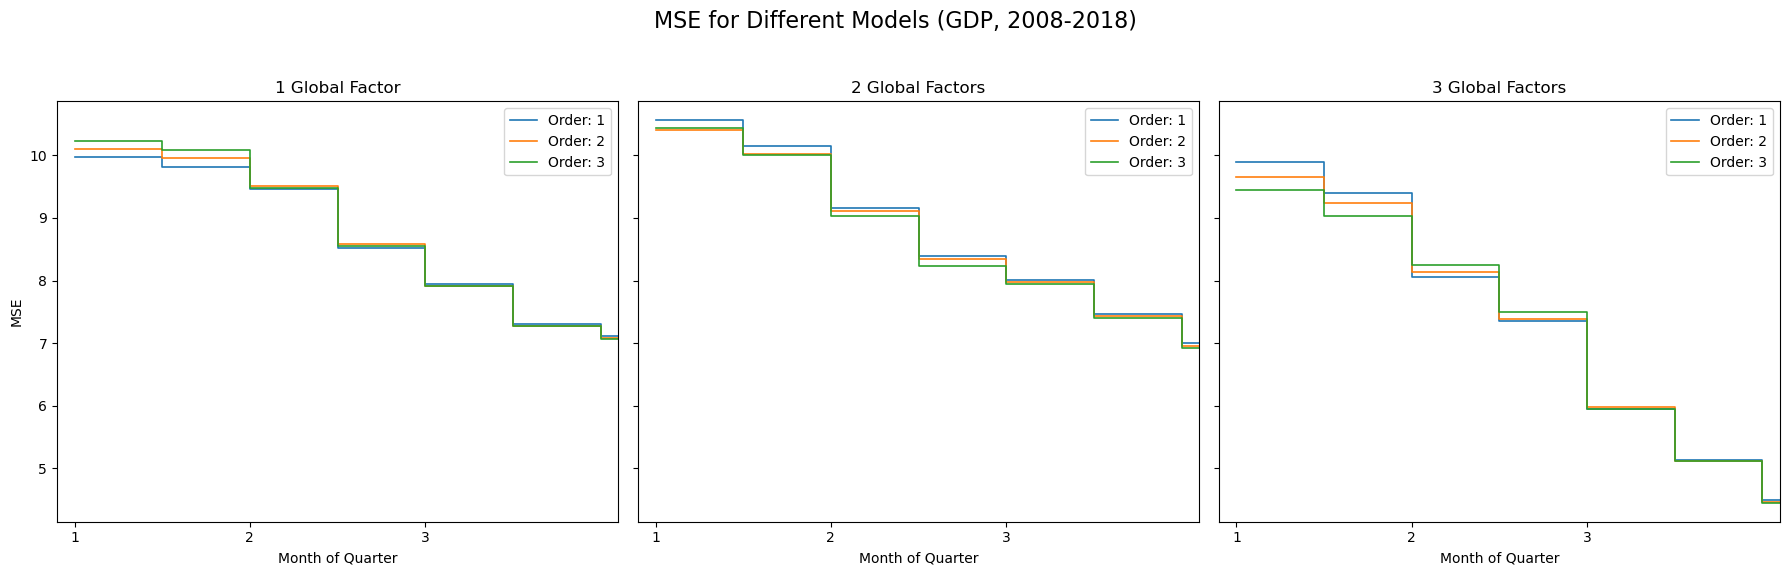

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


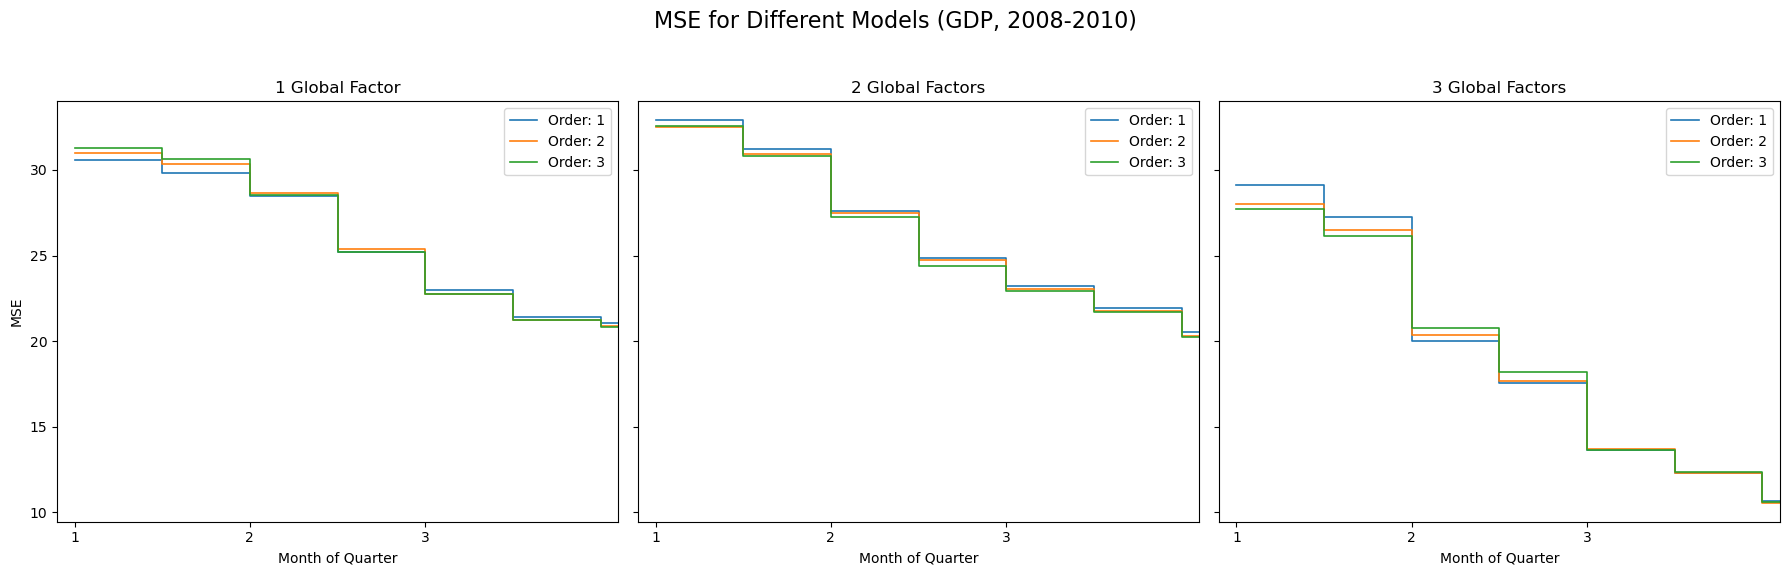

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


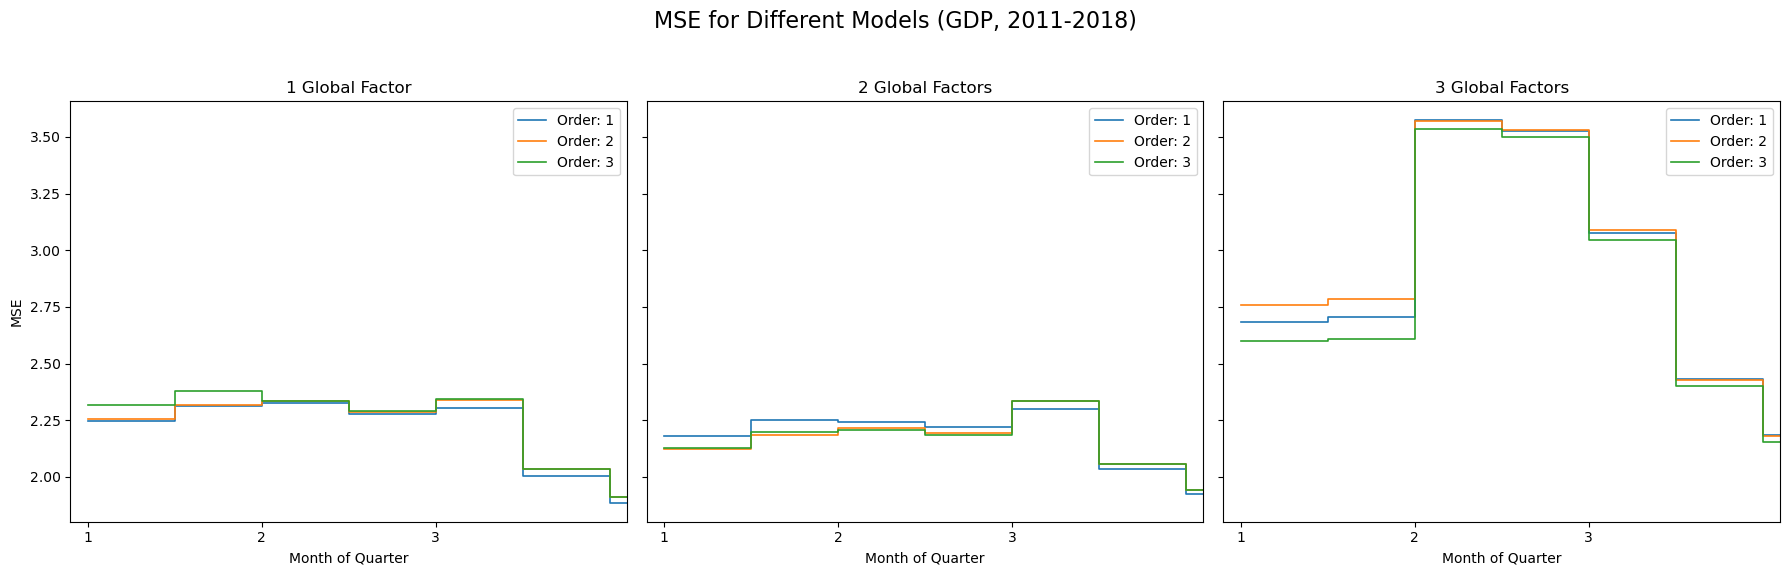

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


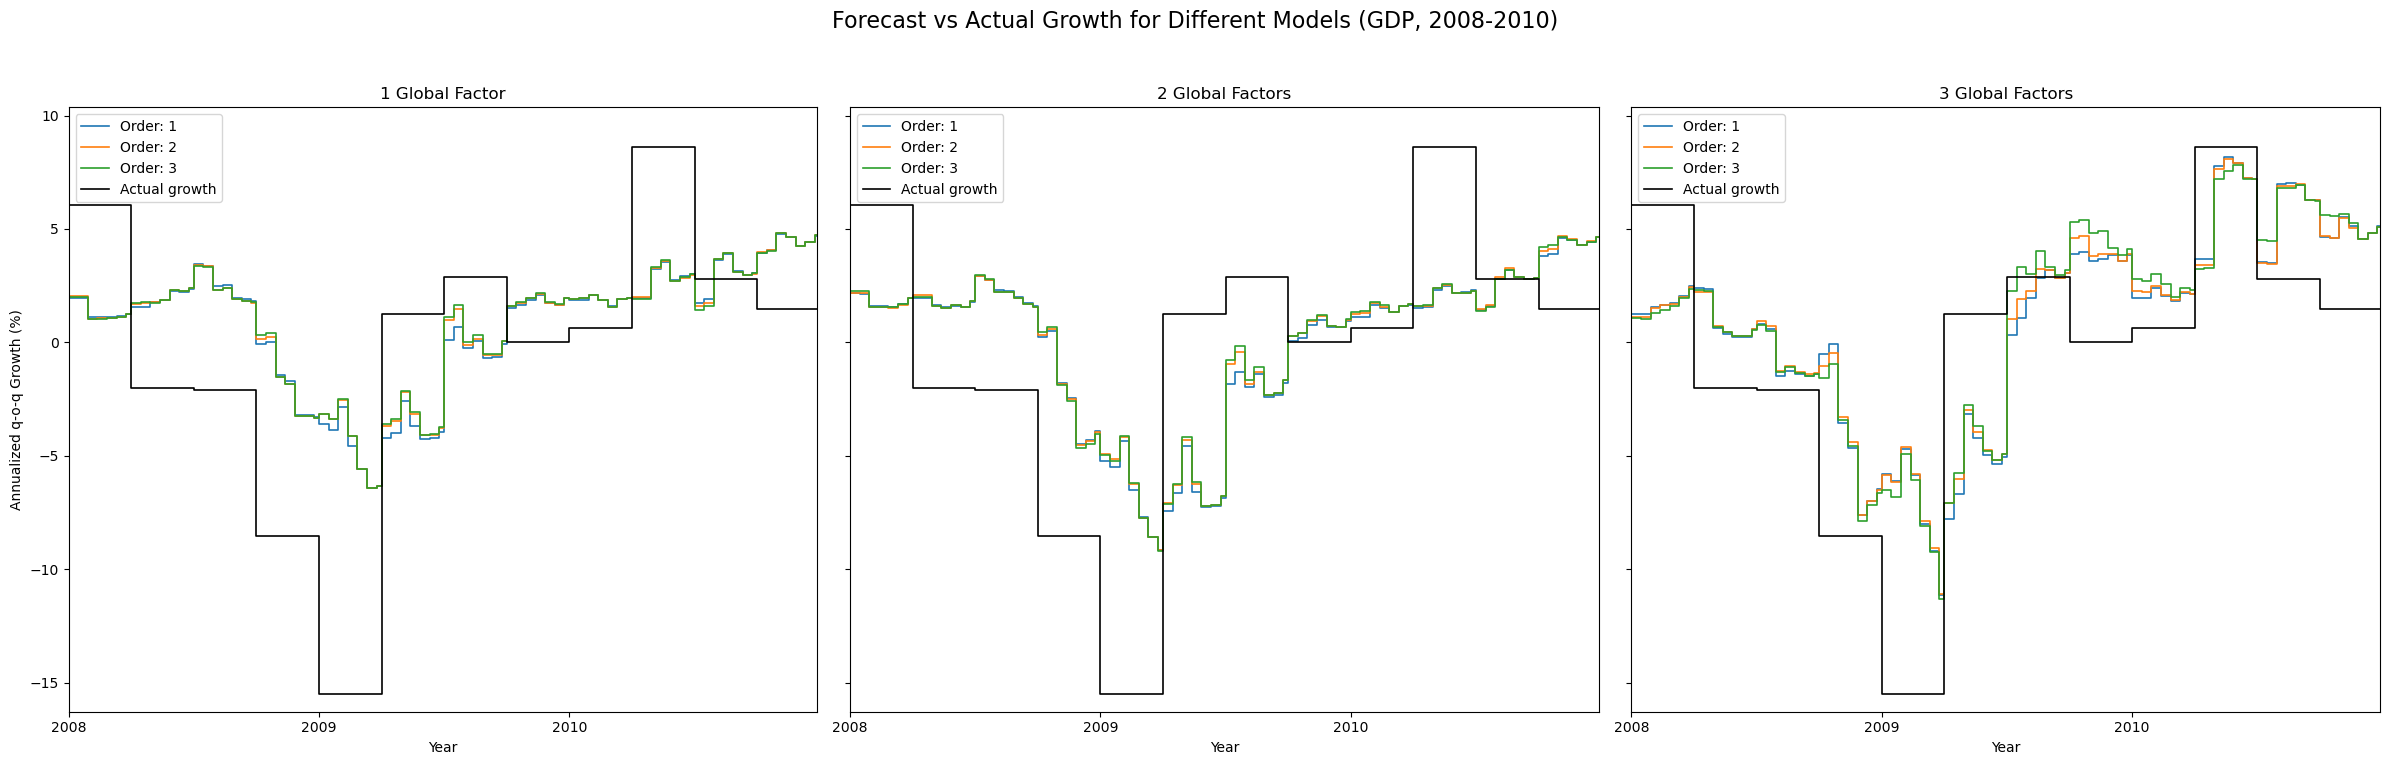

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


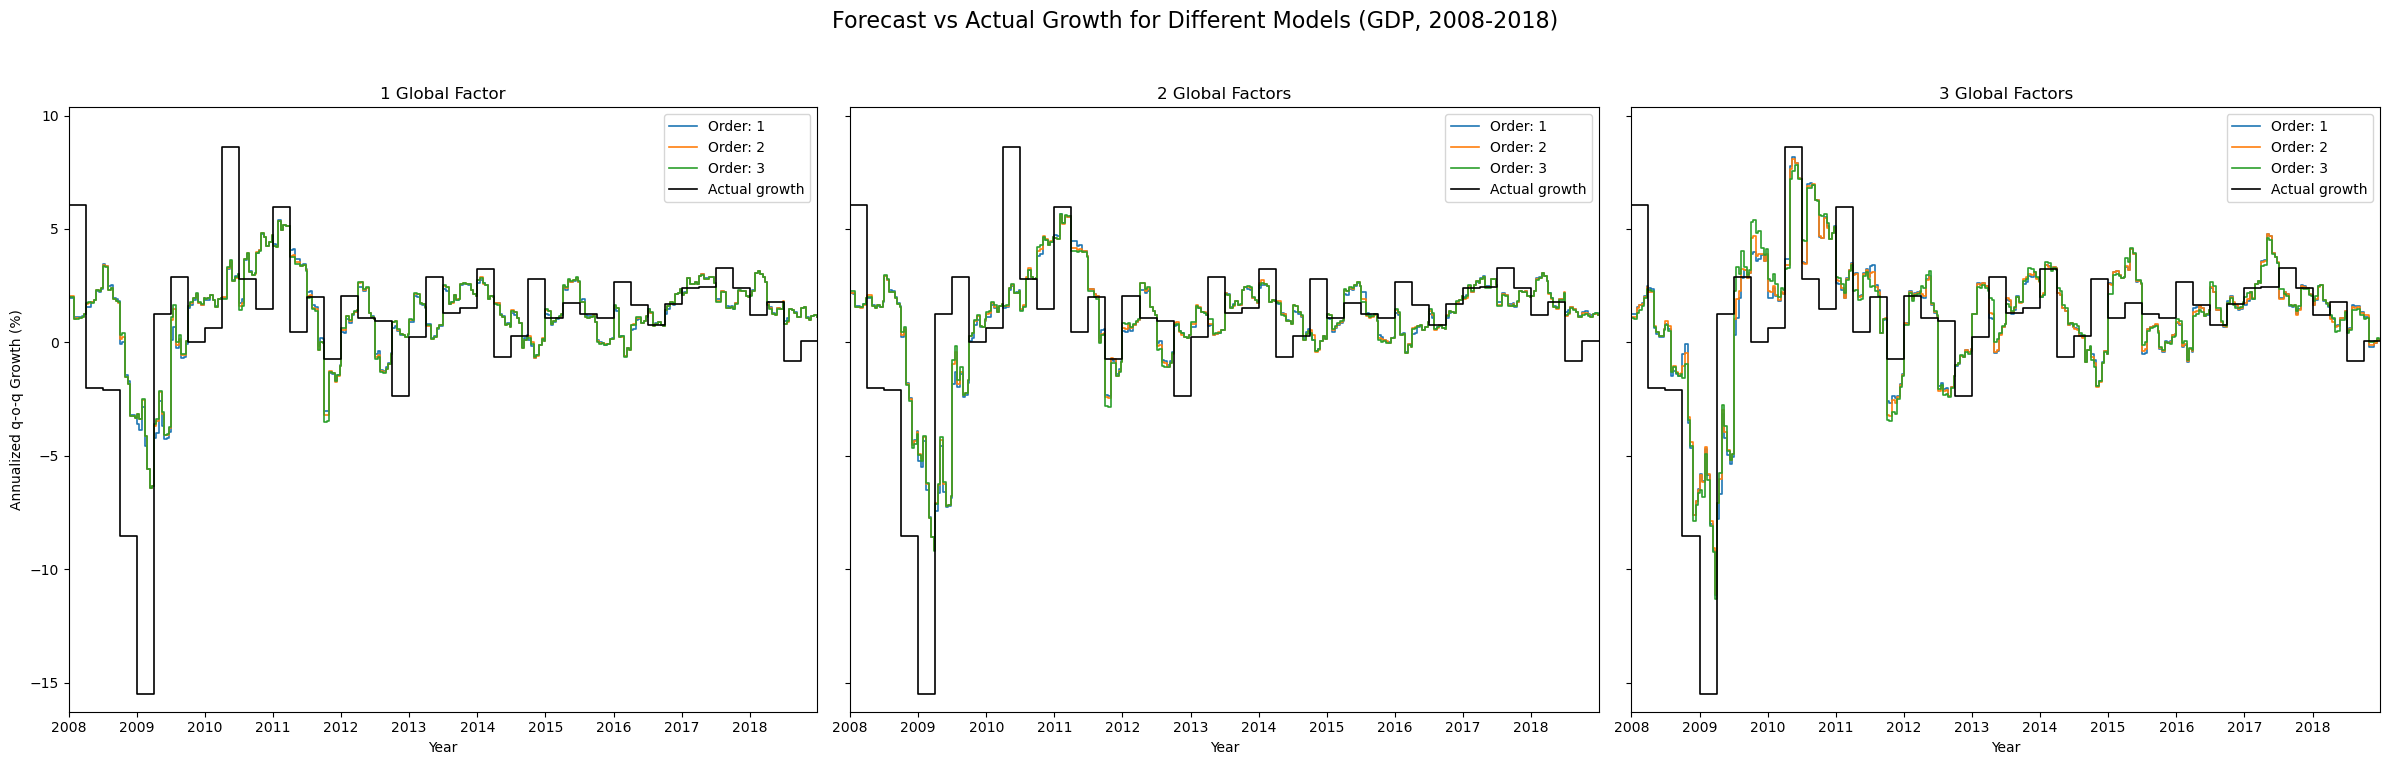

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


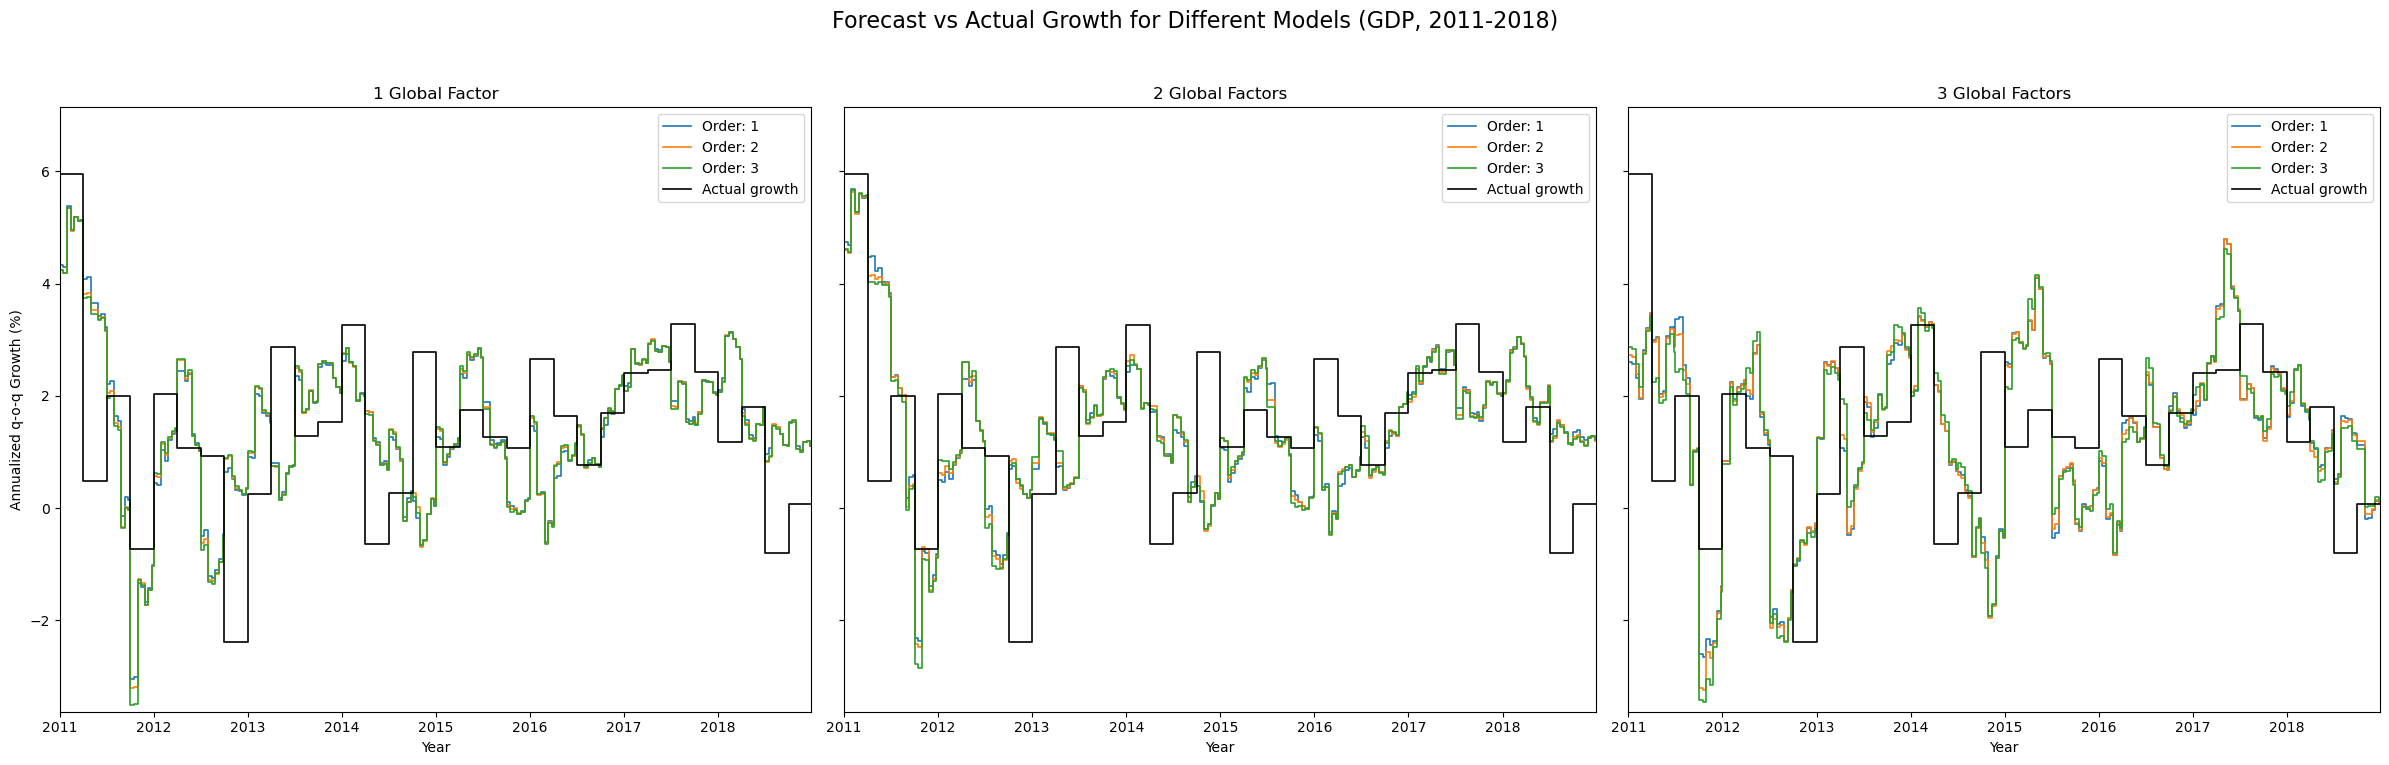

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(24, 8), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()